# Generating Molecules with MolGAN

In this tutorial, we will train a MolGAN network on the tox21 dataset which is a dataset of 12,060 training samples and 647 test samples of chemical compounds. The MolGAN network was first introduced in "MolGAN: An implicit generative model for small molecular graphs" by Cao and Kipf. It uses a GAN directly on graph data and a reinforcement learning objective to induce the network to generate molecules with certain chemical properties.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

*Add link*

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands.

In [110]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

'2.6.0.dev'

Import the packages you'll need.

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import deepchem as dc
import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
import tensorflow as tf
from tensorflow import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

Download, load, and extract the SMILES strings from the tox21 dataset. The original paper used the QM9 dataset, however we use the tox21 dataset here to save time.

In [112]:
# Download from MolNet
# Try tox21 or LIPO dataset
tasks, datasets, transformers = dc.molnet.load_tox21()
df = pd.DataFrame(data={'smiles': datasets[0].ids})

Specify the maximum number of atoms to enocde for the featurizer and the MolGAN network.

In [113]:
num_atoms = 12

In [114]:
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


Uncomment the first line if you want to subsample from the full dataset.

In [115]:
#data = df[['smiles']].sample(4000, random_state=42)
data = df

Initialize the featurizer with the maxmimum number of atoms per molecule

In [116]:
# create featurizer
feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms)

Extract the smiles from the dataframe as a list of strings

In [117]:
smiles = data['smiles'].values

In [118]:
len(smiles)

6264

Filter out the molecules with too many atoms to reduce the number of unnecessary error messages in later steps.

In [119]:
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]

RDKit WARNING: [17:00:33] WARNING: not removing hydrogen atom without neighbors


In [120]:
len(filtered_smiles)

2081

In [121]:
# featurize molecules
features = feat.featurize(filtered_smiles)

Failed to featurize datapoint 0, CC(O)(P(=O)(O)O)P(=O)(O)O. Appending empty array
Exception message: 15
Failed to featurize datapoint 11, O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ca+2]. Appending empty array
Exception message: 20
RDKit WARNING: [17:00:34] WARNING: not removing hydrogen atom without neighbors
Failed to featurize datapoint 12, F[B-](F)(F)F.[H+]. Appending empty array
Exception message: 5
Failed to featurize datapoint 14, [I-].[K+]. Appending empty array
Exception message: 19
Failed to featurize datapoint 16, C[Si](C)(C)N[Si](C)(C)C. Appending empty array
Exception message: 14
Failed to featurize datapoint 17, C=CC(=O)OCCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 20, CCC[Si](OC)(OC)OC. Appending empty array
Exception message: 14
Failed to featurize datapoint 25, ClCOCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 27, [Cu]I. Appending empty array
Exception message: 29
Failed to featurize datapoint 30, CO[Si](C)(C)

In [122]:
len(features)

2081

Remove more invalid molecules.

In [123]:
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ]
print(indices)
features = [features[i] for i in indices]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 18, 19, 21, 22, 23, 24, 26, 28, 29, 31, 34, 35, 36, 37, 38, 43, 46, 47, 48, 50, 51, 52, 53, 56, 58, 59, 60, 62, 63, 64, 65, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 83, 84, 85, 86, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 109, 110, 111, 112, 113, 114, 115, 119, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 143, 144, 145, 149, 150, 157, 159, 164, 165, 169, 170, 171, 172, 173, 174, 176, 177, 179, 181, 182, 184, 186, 188, 189, 191, 192, 196, 197, 198, 199, 202, 205, 206, 207, 208, 209, 213, 215, 216, 219, 220, 221, 222, 225, 226, 227, 229, 231, 232, 233, 234, 235, 236, 237, 239, 240, 244, 247, 248, 249, 252, 254, 255, 256, 257, 258, 261, 262, 264, 265, 266, 268, 269, 270, 273, 274, 275, 277, 278, 280, 283, 285, 286, 287, 288, 289, 292, 297, 298, 299, 300, 301, 302, 303, 304, 306, 307, 308, 309, 312, 313, 314, 315, 318, 319, 320, 324, 325, 326, 327, 328, 329, 330, 331, 335, 336, 337, 338,

In [124]:
len(features)

1352

Instantiate the MolGAN model and set the learning rate and maximum number of atoms as the size of the vertices. Then, we create the dataset in the format of the input to MolGAN.

In [125]:
# create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=num_atoms)
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

Define the iterbatches function because the gan_fit function requires an iterable for the batches.

In [126]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

Train the model with the fit_gan function and generate molecules with the predict_gan_generator function.

In [127]:
gan.fit_gan(iterbatches(10), generator_steps=0.2, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(1000)

Ending global_step 139: generator average loss 3.34256, discriminator average loss -8.27031
TIMING: model fitting took 6.249 s
Generating 1000 samples


Convert the generated graphs to RDKit molecules.

In [128]:
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))

RDKit WARNING: [17:00:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
RDKit ERROR: [17:00:57] Explicit valence for atom # 0 O, 22, is greater than permitted
RDKit ERROR: [17:00:57] Explicit valence for atom # 0 C, 11, is greater than permitted
RDKit ERROR: [17:00:57] Explicit valence for atom # 2 O, 22, is greater than permitted
RDKit ERROR: [17:00:57] Explicit valence for atom # 4 F, 19, is greater than permitted
RDKit ERROR: [17:00:57] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [17:00:57] Explicit valence for atom # 0 O, 12, is greater than permitted
RDKit ERROR: [17:00:57] Explicit valence for atom # 0 C, 11, is greater than permitted
RDKit ERROR: [17:00:57] Explicit valence for atom # 4 O, 24, is greater than permitted
RDKit WARNING: [17:00:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
RDKit ERROR: [17:00:57] Explicit valence for ato

1000 molecules generated


RDKit WARNING: [17:00:58] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
RDKit ERROR: [17:00:58] Explicit valence for atom # 0 O, 12, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 0 C, 11, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 0 O, 12, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 1 O, 23, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 0 O, 12, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 0 O, 11, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 0 O, 14, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 2 O, 23, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 0 O, 12, is greater than permitted
RDKit ERROR: [17:00:58] Explicit valence for atom # 0 O, 12, is greater than permitted
RD

Remove invalid molecules from list.

In [129]:
nmols = list(filter(lambda x: x is not None, nmols))

Print out the number of valid molecules, but training can be unstable so some the number can vary significantly.

In [130]:
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

478 valid molecules


Remove duplicate generated molecules.

In [131]:
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
print ("{} unique valid molecules".format(len(nmols_viz)))

18 unique valid molecules


Print out up to 100 unique valid molecules.

In [132]:
img = Draw.MolsToGridImage(nmols_viz[0:100], molsPerRow=5, subImgSize=(250, 250), maxMols=100, legends=None, useSVG=True)

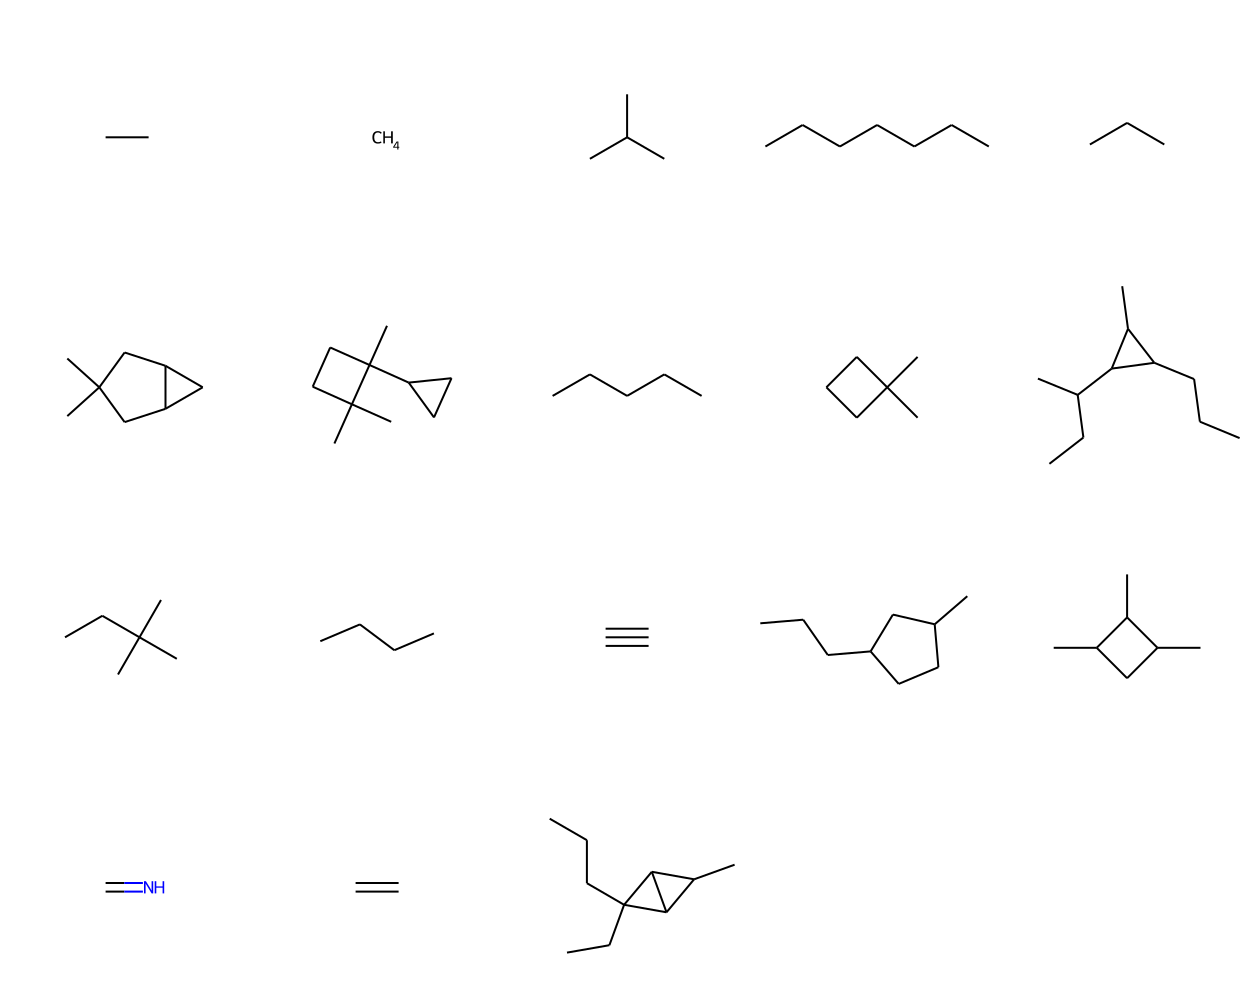

In [133]:
img